In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

# to get consistent results after multiple runs
tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

864538487/864538487 [==============================] - 9s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736557430/5736557430 [==============================] - 58s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528640507/5528640507 [==============================] - 55s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
# preparing data
# generate CSV metadata file to read img paths and labels from it
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# generate CSV files for all data portions, labeling nevus and seborrheic keratosis
# as 0 (benign), and melanoma as 1 (malignant)
# you should replace "data" path to your extracted dataset path
# don't replace if you used download_and_extract_dataset() function
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
# training parameters
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

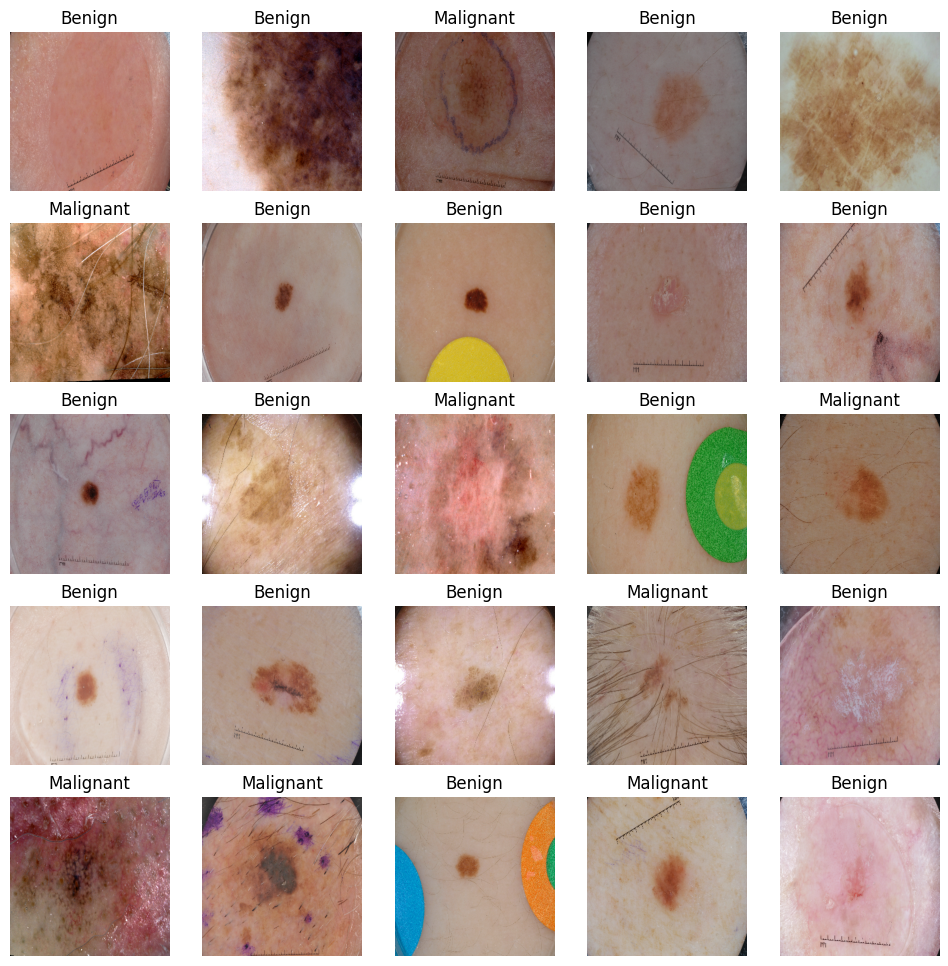

In [ ]:
#Code from https://www.thepythoncode.com/article/skin-cancer-detection-using-tensorflow-in-python
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')
        
show_batch(batch)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


In [ ]:
def build_inception_v3_model(input_shape=(299, 299, 3), n_classes=2):
    # Load the pre-trained InceptionV3 model without the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for our classification task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
model = build_inception_v3_model()

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Set the training parameters
epochs = 20
steps_per_epoch = n_training_samples // batch_size
validation_steps = n_validation_samples // batch_size

# Train the model using the specified parameters
history = model.fit(train_ds,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_ds,
                    validation_steps=validation_steps)

Epoch 1/20
31/31 [==============================] - 904s 23s/step - loss: 0.7685 - accuracy: 0.7586 - val_loss: 0.4837 - val_accuracy: 0.7891
Epoch 2/20
31/31 [==============================] - 553s 18s/step - loss: 0.4063 - accuracy: 0.8115 - val_loss: 0.4443 - val_accuracy: 0.8047
Epoch 3/20
31/31 [==============================] - 556s 18s/step - loss: 0.3947 - accuracy: 0.8070 - val_loss: 0.4534 - val_accuracy: 0.8203
Epoch 4/20
31/31 [==============================] - 550s 18s/step - loss: 0.3593 - accuracy: 0.8271 - val_loss: 0.6594 - val_accuracy: 0.7734
Epoch 5/20
31/31 [==============================] - 562s 18s/step - loss: 0.4008 - accuracy: 0.8105 - val_loss: 0.4875 - val_accuracy: 0.7734
Epoch 6/20
31/31 [==============================] - 555s 18s/step - loss: 0.3874 - accuracy: 0.8246 - val_loss: 0.4482 - val_accuracy: 0.8125
Epoch 7/20
31/31 [==============================] - 558s 18s/step - loss: 0.3667 - accuracy: 0.8211 - val_loss: 0.5360 - val_accuracy: 0.6719
Epoch 

In [ ]:
# Read the test dataset metadata from a CSV file
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)

# Calculate the number of test samples and print it
n_test_samples = len(df_test)
print("Number of test samples:", n_test_samples)

# Create a TensorFlow dataset from the test metadata
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

Number of test samples: 600


In [ ]:
# preprocess data
test_ds = test_ds.map(process_path)

In [ ]:
# Define a function to prepare a dataset for evaluation
def prepare_for_evaluation(ds, batch_size=64):
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

# Prepare the test dataset for evaluation using the defined function
test_ds = prepare_for_evaluation(test_ds, batch_size=batch_size)

In [ ]:
#Get the test loss and accuracy
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

10/10 [==============================] - 400s 37s/step - loss: 0.5077 - accuracy: 0.7617
Test loss: 0.5076794624328613
Test accuracy: 0.7616666555404663


In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
def build_densenet_model(input_shape=(299, 299, 3), n_classes=2):
    # Load the pre-trained DenseNet121 model without the top layers
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for our classification task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [ ]:
densenet_model = build_densenet_model()

densenet_model.compile(optimizer=RMSprop(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [ ]:
epochs = 20
steps_per_epoch = n_training_samples // batch_size
validation_steps = n_validation_samples // batch_size
densenet_history = densenet_model.fit(train_ds,
                                      epochs=epochs,
                                      steps_per_epoch=steps_per_epoch,
                                      validation_data=valid_ds,
                                      validation_steps=validation_steps)


Epoch 1/20
31/31 [==============================] - 961s 26s/step - loss: 0.5820 - accuracy: 0.7843 - val_loss: 0.4648 - val_accuracy: 0.8125
Epoch 2/20
31/31 [==============================] - 627s 20s/step - loss: 0.4106 - accuracy: 0.8090 - val_loss: 0.5343 - val_accuracy: 0.7578
Epoch 3/20
31/31 [==============================] - 625s 20s/step - loss: 0.4004 - accuracy: 0.8070 - val_loss: 0.4520 - val_accuracy: 0.8438
Epoch 4/20
31/31 [==============================] - 622s 20s/step - loss: 0.3769 - accuracy: 0.8150 - val_loss: 0.5837 - val_accuracy: 0.7969
Epoch 5/20
31/31 [==============================] - 620s 20s/step - loss: 0.3770 - accuracy: 0.8311 - val_loss: 0.4775 - val_accuracy: 0.7891
Epoch 6/20
31/31 [==============================] - 626s 20s/step - loss: 0.3623 - accuracy: 0.8347 - val_loss: 0.5030 - val_accuracy: 0.7266
Epoch 7/20
31/31 [==============================] - 615s 20s/step - loss: 0.3578 - accuracy: 0.8261 - val_loss: 0.5851 - val_accuracy: 0.6172
Epoch 

In [ ]:
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_test_samples = len(df_test)
print("Number of test samples:", n_test_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

Number of test samples: 600


In [ ]:
test_ds = test_ds.map(process_path)

In [ ]:
def prepare_for_evaluation(ds, batch_size=64):
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

test_ds = prepare_for_evaluation(test_ds, batch_size=batch_size)

In [ ]:
# Evaluate DenseNet121 model
test_loss, test_accuracy = densenet_model.evaluate(test_ds)
print("DenseNet Test loss:", test_loss)
print("DenseNet Test accuracy:", test_accuracy)

10/10 [==============================] - 396s 37s/step - loss: 0.4368 - accuracy: 0.8167
DenseNet Test loss: 0.4367757737636566
DenseNet Test accuracy: 0.8166666626930237


In [ ]:
test_loss, test_accuracy = densenet_model.evaluate(test_ds)
print("DenseNet Test loss:", test_loss)
print("DenseNet Test accuracy:", test_accuracy)

10/10 [==============================] - 401s 37s/step - loss: 0.4368 - accuracy: 0.8167
DenseNet Test loss: 0.4367757737636566
DenseNet Test accuracy: 0.8166666626930237


In [ ]:
# Evaluate InceptionV3 model
inception_v3_predictions = model.predict(test_ds)
inception_v3_predicted_labels = np.argmax(inception_v3_predictions, axis=1)

10/10 [==============================] - 370s 34s/step


In [ ]:
# Evaluate DenseNet121 model
densenet_predictions = densenet_model.predict(test_ds)
densenet_predicted_labels = np.argmax(densenet_predictions, axis=1)

10/10 [==============================] - 406s 38s/step


In [ ]:
# Get the true labels from the test dataset
n_random_test_images = 5
random_indices = np.random.randint(0, n_test_samples, size=n_random_test_images)

In [38]:
!pip install tdqm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=b9b27b3bfc7b21d3bb91df2b465a2db5203273bb071193e84cb8226d20ec5d8b
  Stored in directory: /root/.cache/pip/wheels/cf/cf/87/969aabe5f7efa9beb7f0de846653f5cbf36bafe358451132df
Successfully built tdqm


In [39]:
from tqdm import tqdm

# Get the true labels from the test dataset
random_test_images = np.array([x.numpy() for i, (x, _) in enumerate(tqdm(test_ds.unbatch(), total=n_test_samples)) if i in random_indices])
test_true_labels = np.array([y.numpy() for _, y in tqdm(test_ds.unbatch(), total=n_test_samples)])
random_test_true_labels = test_true_labels[random_indices]

100%|██████████| 600/600 [03:50<00:00,  2.60it/s]


In [ ]:
#Predict the labels for the random test images
inception_v3_random_predictions = model.predict(random_test_images)
inception_v3_random_predicted_labels = np.argmax(inception_v3_random_predictions, axis=1)

1/1 [==============================] - 4s 4s/step


In [ ]:
#Predict the labels for the random test images
densenet_random_predictions = densenet_model.predict(random_test_images)
densenet_random_predicted_labels = np.argmax(densenet_random_predictions, axis=1)

1/1 [==============================] - 4s 4s/step


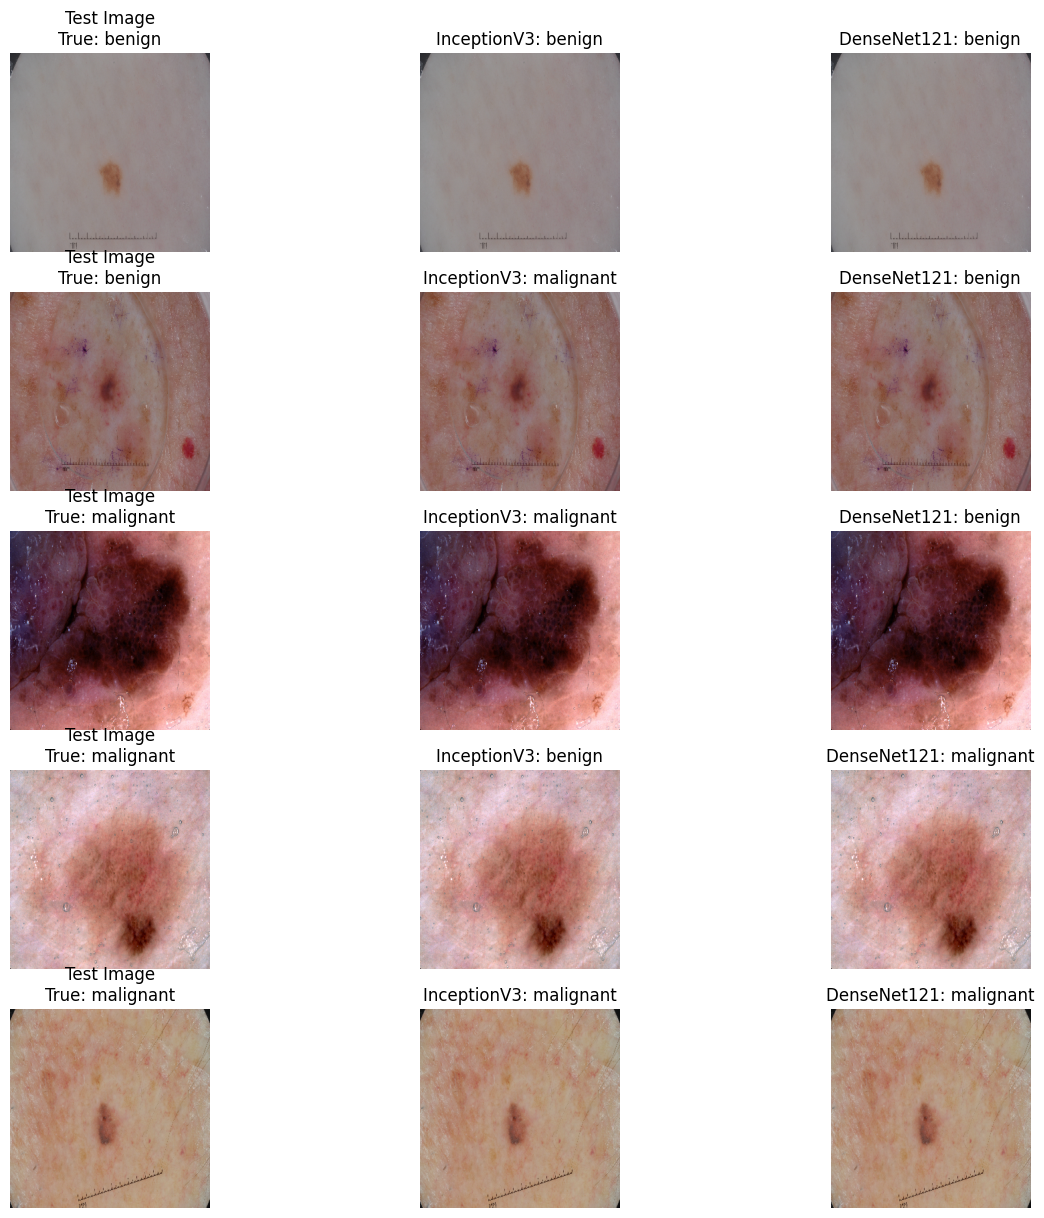

In [41]:
# Create a plot with subplots for each random test image and their predictions
fig, axes = plt.subplots(n_random_test_images, 3, figsize=(15, 3 * n_random_test_images))

for i, img in enumerate(random_test_images):
    true_label = class_names[random_test_true_labels[i]]

    # Display the test image with the true label
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Test Image\nTrue: {true_label}')

    # Display the test image with the InceptionV3 model's predicted label
    axes[i, 1].imshow(img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'InceptionV3: {class_names[inception_v3_random_predicted_labels[i]]}')

    # Display the test image with the DenseNet121 model's predicted label
    axes[i, 2].imshow(img)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'DenseNet121: {class_names[densenet_random_predicted_labels[i]]}')

plt.show()